<a href="https://colab.research.google.com/github/Luwhee/1140804/blob/master/CRAAE02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import與設定**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("images/SRAAE", exist_ok=True)

**Dataset（MNIST）**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform,
    ),
    batch_size=32,
    shuffle=True,
)

**Residual Block**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
        )
    def forward(self, x):
        return torch.relu(x + self.block(x))

**Encoder**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoding_dim=2):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            ResidualBlock(1000),
            nn.Linear(1000, encoding_dim)
        )
    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)

**Decoder(Conditional)**

In [ ]:
class Decoder(nn.Module):
    def __init__(self, encoding_dim=2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(encoding_dim+10, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            ResidualBlock(1000),
            nn.Linear(1000, 28*28),
            nn.Sigmoid()
        )
    def forward(self, z, y):
        x = torch.cat([z, y], dim=1)
        x = self.fc(x)
        return x.view(-1, 1, 28, 28)

**Discriminator(Latent)**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,encoding_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(encoding_dim,64),
            nn.ReLU(),
            #nn.Dropout(0.25),
            #nn.Linear(1000,1000),
            #nn.ReLU(),
            #nn.Dropout(0.25),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.model(z)

**初始化模型與Optimizer**

In [ ]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)

opt_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
opt_d = optim.Adam(discriminator.parameters(),lr=1e-4,betas=(0.5, 0.999))

criterion_adv = nn.BCELoss()
criterion_rec = nn.MSELoss()

**Training Loop**

In [16]:
epochs = 100
lambda_adv = 0.1
log = {
    "d_loss": [],
    "d_acc": [],
    "g_acc": [],
    "mse": [],
    "g_adv": []
}

for epoch in range(1, epochs + 1):
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels_oh = torch.nn.functional.one_hot(labels, 10).float().to(device)

        batch_size = imgs.size(0)
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        z_real = torch.randn(batch_size, 2).to(device)
        z_fake = encoder(imgs)

        d_real = discriminator(z_real)
        d_fake = discriminator(z_fake.detach())

        d_loss = (criterion_adv(d_real, valid) +
                  criterion_adv(d_fake, fake)) / 2

        opt_d.zero_grad()
        d_loss.backward()
        opt_d.step()

        d_acc = ((d_real > 0.5).float().mean() +
                 (d_fake < 0.5).float().mean()) / 2

        # ---------------------
        # Train Autoencoder
        # ---------------------
        recon = decoder(z_fake, labels_oh)
        mse_loss = criterion_rec(recon, imgs)

        g_adv = criterion_adv(discriminator(z_fake), valid)

        opt_ae.zero_grad()
        loss_G = mse_loss + lambda_adv * g_adv
        loss_G.backward()
        opt_ae.step()

        g_acc = (discriminator(z_fake) > 0.5).float().mean()

    log["d_loss"].append(d_loss.item())
    log["d_acc"].append(d_acc.item())
    log["g_acc"].append(g_acc.item())
    log["mse"].append(mse_loss.item())
    log["g_adv"].append(g_adv.item())

    print(f"[{epoch}] D_loss={d_loss:.4f};D_acc={d_acc:.2f}|G_acc={g_acc:.2f};MSE={mse_loss:.4f};G_adv={g_adv:.2f}")

    #if epoch % 10 == 0:
    z = torch.randn(10, 2).to(device)
    labels = torch.eye(10).to(device)
    imgs = decoder(z, labels)
    grid = make_grid(imgs, nrow=10, normalize=True)
    save_image(grid, f"images/SRAAE/epoch_{epoch}.png")


[1] D_loss=0.6962;D_acc=0.45|G_acc=0.19;MSE=0.0398;G_adv=0.70
[2] D_loss=0.6937;D_acc=0.45|G_acc=0.69;MSE=0.0373;G_adv=0.69
[3] D_loss=0.6900;D_acc=0.64|G_acc=0.47;MSE=0.0384;G_adv=0.70
[4] D_loss=0.6921;D_acc=0.50|G_acc=0.31;MSE=0.0339;G_adv=0.70
[5] D_loss=0.6929;D_acc=0.47|G_acc=0.56;MSE=0.0337;G_adv=0.69
[6] D_loss=0.6912;D_acc=0.58|G_acc=0.38;MSE=0.0312;G_adv=0.70
[7] D_loss=0.6931;D_acc=0.58|G_acc=0.34;MSE=0.0353;G_adv=0.70
[8] D_loss=0.6937;D_acc=0.45|G_acc=0.50;MSE=0.0331;G_adv=0.69
[9] D_loss=0.6930;D_acc=0.53|G_acc=0.34;MSE=0.0342;G_adv=0.70
[10] D_loss=0.6941;D_acc=0.53|G_acc=0.50;MSE=0.0314;G_adv=0.69
[11] D_loss=0.6950;D_acc=0.48|G_acc=0.47;MSE=0.0345;G_adv=0.69
[12] D_loss=0.6931;D_acc=0.53|G_acc=0.50;MSE=0.0371;G_adv=0.69
[13] D_loss=0.6945;D_acc=0.41|G_acc=0.56;MSE=0.0392;G_adv=0.69
[14] D_loss=0.6910;D_acc=0.56|G_acc=0.34;MSE=0.0340;G_adv=0.70
[15] D_loss=0.6898;D_acc=0.59|G_acc=0.50;MSE=0.0298;G_adv=0.70
[16] D_loss=0.6940;D_acc=0.52|G_acc=0.62;MSE=0.0363;G_adv=0.69
[

**訓練曲線圖**

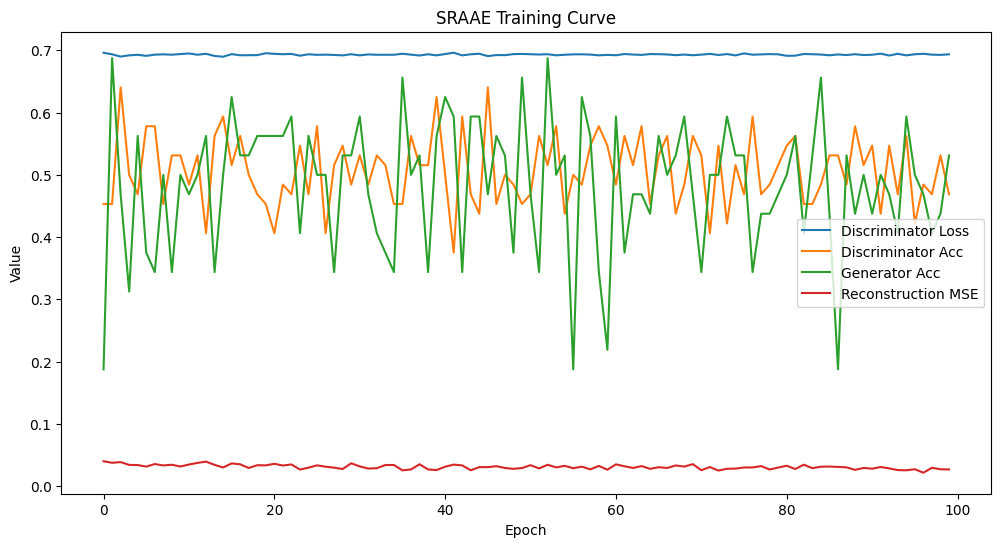

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(log["d_loss"], label="Discriminator Loss")
plt.plot(log["d_acc"], label="Discriminator Acc")
plt.plot(log["g_acc"], label="Generator Acc")
plt.plot(log["mse"], label="Reconstruction MSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("SRAAE Training Curve")
plt.show()